<a href="https://colab.research.google.com/github/Lilllyay/UTS-Blue-Hacks/blob/main/Copy_of_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import re
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train - finalized - train.csv')

In [ ]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24861, 6)


In [ ]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

In [ ]:
# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

In [ ]:
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text
  # remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

In [ ]:
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [ ]:
# call the cleaning function
clean_tweet = preprocess(tweet)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [ ]:
# create hot_labels
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

#defining accuracy metrics
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [ ]:
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [ ]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
311/311 [==============================] - 36s 103ms/step - loss: 0.4579 - accuracy: 0.8433 - f1: 0.8173 - precision: 0.8476 - recall: 0.7949 - val_loss: 0.3266 - val_accuracy: 0.8854 - val_f1: 0.8848 - val_precision: 0.8968 - val_recall: 0.8733
Epoch 2/10
311/311 [==============================] - 31s 101ms/step - loss: 0.2358 - accuracy: 0.9216 - f1: 0.9210 - precision: 0.9315 - recall: 0.9109 - val_loss: 0.3074 - val_accuracy: 0.8862 - val_f1: 0.8877 - val_precision: 0.8947 - val_recall: 0.8808
Epoch 3/10
311/311 [==============================] - 31s 100ms/step - loss: 0.1536 - accuracy: 0.9477 - f1: 0.9478 - precision: 0.9510 - recall: 0.9447 - val_loss: 0.3725 - val_accuracy: 0.8800 - val_f1: 0.8805 - val_precision: 0.8844 - val_recall: 0.8767
Epoch 4/10
311/311 [==============================] - 32s 102ms/step - loss: 0.1081 - accuracy: 0.9639 - f1: 0.9638 - precision: 0.9654 - recall: 0.9623 - val_loss: 0.4480 - val_accuracy: 0.8665 - val_f1: 0.8665 - val_precision: 

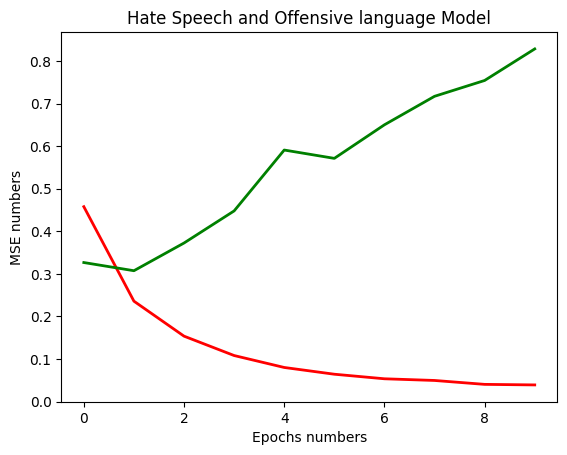

In [ ]:
#report acccuracy
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [ ]:
!pip3 install flask_ngrok
!pip3 install pyngrok==4.1.1
!ngrok authtoken '2bFHzyDrvYy1BPHTyJ7m42eA2tZ_4uxmxZRaYHazrbXVvsYP9'

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=8445368ade29822a12a3092b5f51c918d45ca535c9eb2a6df664f5f49575388b
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask_ngrok import run_with_ngrok
import numpy as np
from flask import Flask, request, render_template
import pickle

template_folder = '/content/drive/MyDrive/Colab Notebooks/UTSHackathon/template'
static_folder = '/content/drive/MyDrive/Colab Notebooks/UTSHackathon/static'

app = Flask(__name__,template_folder=template_folder,static_folder=static_folder)
run_with_ngrok(app)

@app.route('/aboutUS', methods=['GET'])
def aboutUS():
  return render_template("aboutus.html")

@app.route('/', methods=['GET'])
def home():
  return render_template("index (1).html")

@app.route('/login', methods=['GET'])
def login():
  return render_template("login.html")

@app.route('/yourvoice', methods=['GET'])
def yourvoice():
  voice = request.form.get('message')
  print(voice)
  return render_template("yourvoice.html")

@app.route('/Send', methods=['POST','GET'])
def predict():
  test_data= request.form.get('message')
  df = cv.transform([test_data]).toarray()
  predictions = model.predict(df)
  print(predictions)
  if predictions == ['Offensive Language Detected']:
    return render_template("index (1).html", pred="{}.Your passage may contain sterotypes or aggresive language that are offensive towards a certain minority group.\nIt is always important to consider the context you are speaking in and respect the culture and beliefs of other groups. Please consider revising your sentence.".format(predictions))
  elif predictions == ['Hate Speech Detected']:
    return render_template("index (1).html", pred="{}. Your passage contains hate language towards someone or some group.\nNote that such unfriendly language may greatly jeopardize their mental well=being and reflect badly on you\nWe understand that you might have written it in a frustrating context, but it is always crucial to consider the impacts of your words on others. Please do not swear at or target others.".format(predictions))
  else:
    return render_template("index (1).html", pred="{}. Your passage is good! Good job helping us break the societal barriers of biases and stereotypes!".format(predictions))


if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://6fb6-34-138-53-227.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:11:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:11:40] "GET /static/style%20(1).css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:11:40] "GET /static/DEI.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:11:41] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:12:31] "POST /Send HTTP/1.1" 200 -


['Offensive Language Detected']


INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:12:31] "GET /static/style%20(1).css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Jan/2024 20:12:31] "GET /static/DEI.jpg HTTP/1.1" 304 -
